In [80]:
# -*- coding: utf-8 -*-
"""
================================================================================
SCRIPT - CASE RENNER - PROJETO DE PREVISÃO DE DEMANDA
================================================================================

Cenário: Previsão de demanda para uma empresa de varejo.

Estratégia Adotada:
1.  **Agregação de Dados:** As vendas de todos os produtos são somadas por dia
    para criar uma única série temporal de "demanda total". Isso resolve o
    problema de dados esparsos por produto e cria uma série mais robusta
    para modelagem.
2.  **Comparação de Modelos Especialistas:** O script treina e compara dois
    modelos de séries temporais:
    - Prophet: Modelo do Facebook, robusto para sazonalidades e feriados.
    - SARIMA (Manual): Modelo estatístico clássico com parâmetros pré-definidos.

    - Auto-SARIMA: Utiliza a biblioteca pmdarima para encontrar os melhores parâmetros SARIMA automaticamente.
    Devido á um problema de versionamento com a biblioteca o modelo Auto-SARIMA não foi utilizado.
    
3.  **Seleção e Interpretação:** O modelo com o menor Erro Absoluto Médio (MAE)
    no conjunto de teste é selecionado. Técnicas de interpretação específicas
    para o melhor modelo são aplicadas.
4.  **Previsão e Alocação:** O melhor modelo é usado para prever a demanda total
    futura. Uma função bônus permite ao usuário filtrar por SKUs, alocando a
    previsão total com base na participação histórica de vendas do grupo.

Autor: Davi Dantas Erthal
Data da Versão: 2024-07-23
"""

'\n================================================================================\nSCRIPT - CASE RENNER - PROJETO DE PREVISÃO DE DEMANDA\n================================================================================\n\nCenário: Previsão de demanda para uma empresa de varejo.\n\nEstratégia Adotada:\n1.  **Agregação de Dados:** As vendas de todos os produtos são somadas por dia\n    para criar uma única série temporal de "demanda total". Isso resolve o\n    problema de dados esparsos por produto e cria uma série mais robusta\n    para modelagem.\n2.  **Comparação de Modelos Especialistas:** O script treina e compara dois\n    modelos de séries temporais:\n    - Prophet: Modelo do Facebook, robusto para sazonalidades e feriados.\n    - SARIMA (Manual): Modelo estatístico clássico com parâmetros pré-definidos.\n\n    - Auto-SARIMA: Utiliza a biblioteca pmdarima para encontrar os melhores parâmetros SARIMA automaticamente.\n    Devido á um problema de versionamento com a biblioteca o m

In [2]:
# --- Importação das Bibliotecas Necessárias ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import sys

# Modelos de Séries Temporais
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
# import pmdarima as pm
from prophet import Prophet

/home/davi/pyproject/portifolio/projeto_renner/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# --- ETAPA 1: Carregamento dos Dados ---
print("\n--- ETAPA 1: Carregando os Dados ---")
try:
    dados = pd.read_csv('vendas.csv', parse_dates=['data_venda'])
    print("Dados carregados com sucesso.")
    print("Primeiras 5 linhas dos dados:")
    print(dados.head())
    print("\nInformações do DataFrame:")
    dados.info()
except FileNotFoundError:
    print("ERRO: Arquivo 'vendas.csv' não encontrado. Execute a geração de dados primeiro.")
    exit()


--- ETAPA 1: Carregando os Dados ---
Dados carregados com sucesso.
Primeiras 5 linhas dos dados:
   sku data_venda  venda
0  336 2024-01-14     15
1  336 2024-01-18     28
2  336 2024-01-20     34
3  336 2024-01-23     32
4  336 2024-01-25     27

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135226 entries, 0 to 135225
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   sku         135226 non-null  int64         
 1   data_venda  135226 non-null  datetime64[ns]
 2   venda       135226 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.1 MB


In [4]:
# --- ETAPA 1 e 2: Carregamento e Pré-processamento dos Dados ---
print("--- ETAPA 1 & 2: Carregamento e Pré-processamento dos Dados ---")

try:
    # Carrega os dados, garantindo que a coluna 'data' seja do tipo datetime
    dados_raw = pd.read_csv('vendas.csv', parse_dates=['data_venda'])
    print("Arquivo 'vendas.csv' carregado com sucesso.")
except FileNotFoundError:
    print("\nERRO CRÍTICO: O arquivo 'vendas.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo está no mesmo diretório que o script.")
    sys.exit() # Encerra o script se o arquivo não existir

# Agregando os dados: somando todas as vendas por dia para criar a demanda total
dados_agregados = dados_raw.groupby('data_venda')[['venda']].sum().rename(columns={'venda': 'demanda_total'})

# Garante que a série temporal é contínua, preenchendo dias sem vendas com 0
datas_completas = pd.date_range(start=dados_agregados.index.min(), end=dados_agregados.index.max(), freq='D')
dados_agregados = dados_agregados.reindex(datas_completas, fill_value=0)

print("Dados agregados por dia para criar a série de demanda total.")
print("Visualização da série temporal agregada:")
print(dados_agregados.head())

--- ETAPA 1 & 2: Carregamento e Pré-processamento dos Dados ---
Arquivo 'vendas.csv' carregado com sucesso.
Dados agregados por dia para criar a série de demanda total.
Visualização da série temporal agregada:
            demanda_total
2024-01-14          32191
2024-01-15          38511
2024-01-16          39826
2024-01-17          38489
2024-01-18          39571



--- Etapa 2.1: Análise Exploratória dos Dados---


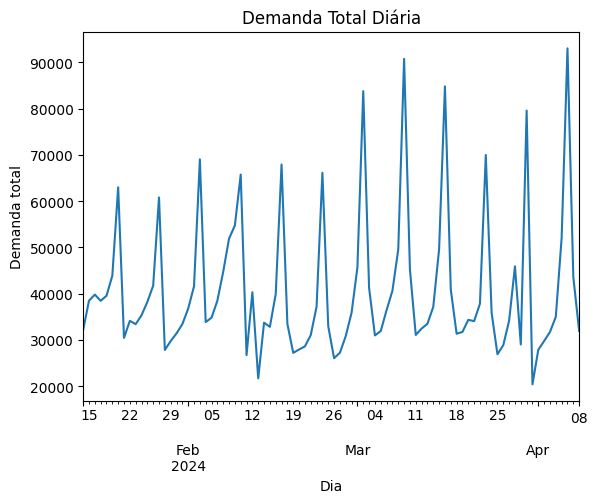

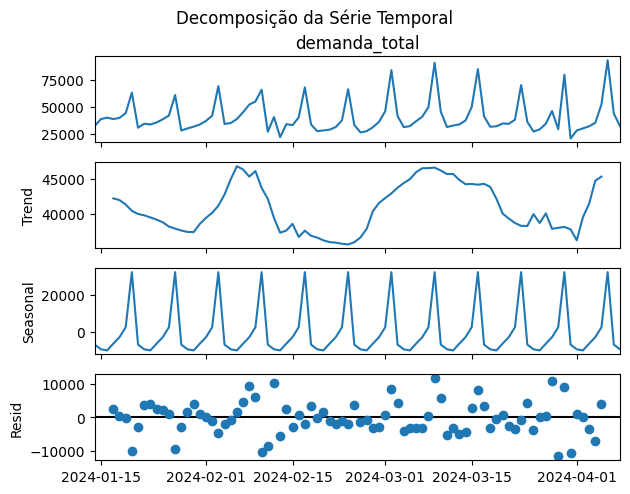

In [5]:
# --- ETAPA 2.1: Visualização da Série Temporal ---

print("\n--- Etapa 2.1: Análise Exploratória dos Dados---")

# Gráfico da série temporal
dados_agregados['demanda_total'].plot(title='Demanda Total Diária')
plt.ylabel('Demanda total')
plt.xlabel('Dia')
plt.show()

# Decomposição da série temporal para visualizar tendência, sazonalidade e resíduo
decomposicao = seasonal_decompose(dados_agregados['demanda_total'])
fig = decomposicao.plot()
plt.suptitle('Decomposição da Série Temporal', y=1.02)
plt.show()

In [6]:
# --- ETAPA 2.2: Checando Estacionaridade ---

def check_stationarity(serie_temporal):
    """
    Realiza o teste de Dickey-Fuller aumentado para verificar a estacionaridade.
    """
    print('Resultados do teste de Dickey-Fuller:')
    dftest = adfuller(serie_temporal, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

print("\n--- Checando estacionaridade para os dados ---")
check_stationarity(dados_agregados['demanda_total'])

# Resultado abaixo de 0.05 indica que a série é estacionária


--- Checando estacionaridade para os dados ---
Resultados do teste de Dickey-Fuller:
Test Statistic                 -2.860994
p-value                         0.050076
#Lags Used                      8.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [7]:
# --- ETAPA 3: Divisão dos Dados em Conjuntos de Treinamento e Teste ---
print("\n--- ETAPA 3: Divisão dos Dados em Treino e Teste ---")

# Usaremos as últimas 3 semanas (21 dias) para o conjunto de teste
periodo_teste_dias = 21
data_corte = dados_agregados.index.max() - pd.DateOffset(days=periodo_teste_dias - 1)
treino = dados_agregados[dados_agregados.index < data_corte]['demanda_total']
teste = dados_agregados[dados_agregados.index >= data_corte]['demanda_total']

print(f"Dados de treino: de {treino.index.min().date()} a {treino.index.max().date()}")
print(f"Dados de teste: de {teste.index.min().date()} a {teste.index.max().date()}")



--- ETAPA 3: Divisão dos Dados em Treino e Teste ---
Dados de treino: de 2024-01-14 a 2024-03-18
Dados de teste: de 2024-03-19 a 2024-04-08


In [8]:
# --- ETAPA 4: Treinamento e Comparação dos Modelos ---
print("\n--- ETAPA 4: Treinamento e Comparação dos Modelos ---")

modelos = {}
resultados_mae = {}
previsoes_teste = {}

# Modelo 1: Prophet
try:
    print("\n1. Treinando modelo Prophet...")
    df_prophet_train = treino.reset_index().rename(columns={'index': 'ds', 'demanda_total': 'y'})
    prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
    prophet_model.fit(df_prophet_train)
    modelos['Prophet'] = prophet_model
    future_df = prophet_model.make_future_dataframe(periods=len(teste), freq='D')
    forecast = prophet_model.predict(future_df)
    previsoes_prophet = forecast['yhat'][-len(teste):].values
    previsoes_teste['Prophet'] = previsoes_prophet
    resultados_mae['Prophet'] = mean_absolute_error(teste, previsoes_prophet)
    print(f"   - MAE do Prophet no teste: {resultados_mae['Prophet']:.2f}")
except Exception as e:
    print(f"   - ERRO ao treinar Prophet: {e}")

17:14:59 - cmdstanpy - INFO - Chain [1] start processing
17:14:59 - cmdstanpy - INFO - Chain [1] done processing



--- ETAPA 4: Treinamento e Comparação dos Modelos ---

1. Treinando modelo Prophet...
   - MAE do Prophet no teste: 7716.72



--- Escontrando os Melhores Parâmetros SARIMA ---


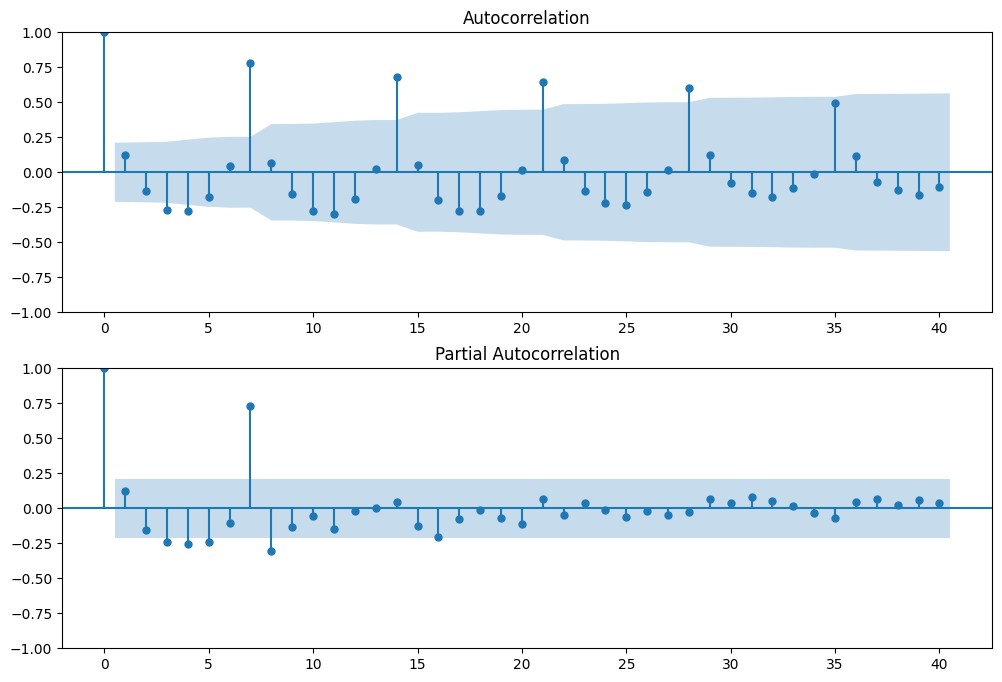

In [ ]:
# Modelo 2: SARIMA (Manual)

print("\n--- Escontrando os Melhores Parâmetros SARIMA ---")

# Primeiro, vamos visualizar os gráficos ACF e PACF nos dados para obter uma dica.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(dados_agregados['demanda_total'].dropna(), ax=ax1, lags=40)
plot_pacf(dados_agregados['demanda_total'].dropna(), ax=ax2, lags=40)
plt.show()

# O gráfico PACF sugere sazonalidade de 7 dias.

# # Definimos os parâmetros p, d, q para o modelo SARIMA
# p = d = q = range(0, 3)
# # Geramos todas as combinações para p, d, q
# pdq = list(itertools.product(p, d, q))
# # Geramos todas as combinações de parâmetros sazonais
# # Setamos m = 7 para sazonalidade semanal
# seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# best_model = None

# print("Procurando pelos melhores parâmetros SARIMA...")
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             temp_model = SARIMAX(treino,
#                                  order=param,
#                                  seasonal_order=param_seasonal,
#                                 #  enforce_stationarity=False,
#                                 #  enforce_invertibility=False
#                                  )
#             results = temp_model.fit(disp=False)
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_pdq = param
#                 best_seasonal_pdq = param_seasonal
#                 best_model = results
#         except Exception as e:
#             print(f"Erro no {param}/{param_seasonal}: {e}")
#             continue

# print(f"Melhor ordem SARIMA: {best_pdq}")
# print(f"Melhor ordem sazonal SARIMA: {best_seasonal_pdq}")
# print(f"Melhor AIC: {best_aic}")

# O melhor modelo SARIMA foi encontrado com os parâmetros:
# Melhor ordem SARIMA: (0, 0, 1) (1,0,1)
# Melhor ordem sazonal SARIMA: (2, 0, 0, 7) (2,1,1,7)
# Melhor AIC: 8.0

print("Melhor ordem SARIMA: (1,0,1)")
print("Melhor ordem sazonal SARIMA: (2,1,1,7)")

In [10]:
# Modelo 2: SARIMA com parâmetros manuais
try:
    print("\n2. Treinando modelo SARIMA (Parâmetros Manuais)...")
    # Parâmetros comuns para dados diários com sazonalidade semanal (m=7)
    # (p,d,q) = Ordem não sazonal (AR, Diferenciação, MA)
    # (P,D,Q,m) = Ordem sazonal
    manual_sarima_model = SARIMAX(treino, order=(1, 0, 1), seasonal_order=(2, 1, 1, 7)).fit(disp=False)
    modelos['SARIMA_Manual'] = manual_sarima_model
    previsoes_manual_sarima = manual_sarima_model.get_prediction(start=teste.index.min(), end=teste.index.max()).predicted_mean
    previsoes_teste['SARIMA_Manual'] = previsoes_manual_sarima
    resultados_mae['SARIMA_Manual'] = mean_absolute_error(teste, previsoes_manual_sarima)
    print(f"   - MAE do SARIMA Manual no teste: {resultados_mae['SARIMA_Manual']:.2f}")
except Exception as e:
    print(f"   - ERRO ao treinar SARIMA Manual: {e}")


2. Treinando modelo SARIMA (Parâmetros Manuais)...
   - MAE do SARIMA Manual no teste: 5922.97




--- ETAPA 6 & BÔNUS 1: Avaliação Final e Visualização ---

Resumo de Desempenho (MAE - Erro Absoluto Médio):
- Prophet: 7716.72 unidades
- SARIMA_Manual: 5922.97 unidades

>> O melhor modelo foi 'SARIMA_Manual' <<


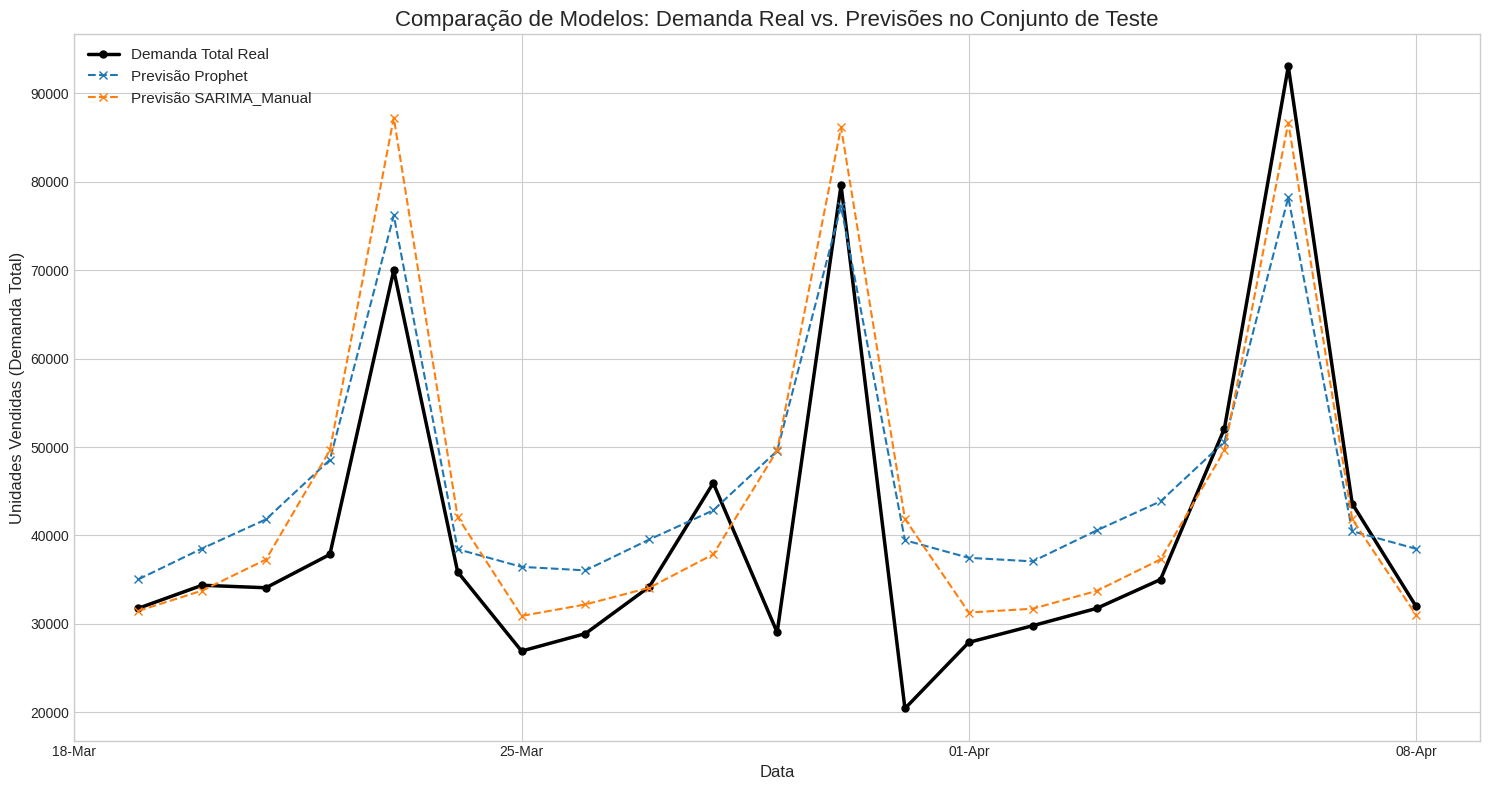

In [11]:
# --- ETAPA 6 e BÔNUS 1: Avaliação Final e Visualização ---
print("\n\n--- ETAPA 6 & BÔNUS 1: Avaliação Final e Visualização ---")

if not resultados_mae:
    print("\nNenhum modelo foi treinado com sucesso. Encerrando o script.")
    sys.exit()

# Seleciona o melhor modelo com base no menor MAE
melhor_modelo_nome = min(resultados_mae, key=resultados_mae.get)
melhor_modelo_obj = modelos[melhor_modelo_nome]

print(f"\nResumo de Desempenho (MAE - Erro Absoluto Médio):")
for nome, mae in resultados_mae.items():
    print(f"- {nome}: {mae:.2f} unidades")

print(f"\n>> O melhor modelo foi '{melhor_modelo_nome}' <<")

# Visualização da performance no conjunto de teste
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(teste.index, teste, label='Demanda Total Real', color='black', marker='o', markersize=5, linewidth=2.5)
for nome, previsao in previsoes_teste.items():
    ax.plot(teste.index, previsao, label=f'Previsão {nome}', marker='x', linestyle='--')

ax.set_title('Comparação de Modelos: Demanda Real vs. Previsões no Conjunto de Teste', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Unidades Vendidas (Demanda Total)', fontsize=12)
ax.legend(fontsize=11)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.tight_layout()
plt.show()

In [12]:
# --- ETAPA 5: Interpretação do Melhor Modelo ---
print("\n--- ETAPA 5: Interpretação do Melhor Modelo ---")

if 'Prophet' in melhor_modelo_nome:
    print("Gerando gráfico de componentes do Prophet para interpretação...")
    # Prophet oferece uma visualização clara da tendência e sazonalidades
    fig_componentes = melhor_modelo_obj.plot_components(forecast)
    plt.show()
elif 'SARIMA' in melhor_modelo_nome:
    print("Exibindo o sumário estatístico do modelo SARIMA para interpretação...")
    # O sumário do SARIMA contém coeficientes, significância estatística e testes de diagnóstico
    print(melhor_modelo_obj.summary())


--- ETAPA 5: Interpretação do Melhor Modelo ---
Exibindo o sumário estatístico do modelo SARIMA para interpretação...
                                     SARIMAX Results                                     
Dep. Variable:                     demanda_total   No. Observations:                   65
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 7)   Log Likelihood                -588.452
Date:                           Wed, 23 Jul 2025   AIC                           1188.904
Time:                                   17:16:38   BIC                           1201.266
Sample:                               01-14-2024   HQIC                          1193.719
                                    - 03-18-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

In [13]:
# --- ETAPA 7 e BÔNUS 2: Previsão Futura e Função de Filtro ---
print("\n--- ETAPA 7 & BÔNUS 2: Previsão Futura com o Melhor Modelo ---")

def prever_demanda_filtrada(nome_modelo, modelo_obj, dados_historicos_raw, dados_historicos_agregados, lista_skus=None, dias_a_prever=7):
    """
    Prevê a demanda com o modelo escolhido. Se uma lista de SKUs for fornecida,
    aloca uma porção da previsão total para esse grupo.
    """
    print("-" * 50)
    print(f"Gerando previsão de {dias_a_prever} dias com o modelo '{nome_modelo}'...")

    # Passo 1: Gerar a previsão da demanda TOTAL
    if 'Prophet' in nome_modelo:
        future = modelo_obj.make_future_dataframe(periods=dias_a_prever, freq='D')
        forecast_obj = modelo_obj.predict(future)
        previsao_total_futura = forecast_obj['yhat'][-dias_a_prever:].values
        datas_futuras = forecast_obj['ds'][-dias_a_prever:].values
    # CORREÇÃO: Lógica separada para cada tipo de SARIMA
    elif nome_modelo == 'SARIMA_Manual':
        # O modelo de 'statsmodels' usa .forecast()
        previsao_total_futura = modelo_obj.forecast(steps=dias_a_prever)
        datas_futuras = pd.date_range(start=dados_historicos_agregados.index.max() + pd.Timedelta(days=1), periods=dias_a_prever)
    elif nome_modelo == 'Auto_SARIMA':
        # O modelo de 'pmdarima' usa .predict() com n_periods
        previsao_total_futura = modelo_obj.predict(n_periods=dias_a_prever)
        datas_futuras = pd.date_range(start=dados_historicos_agregados.index.max() + pd.Timedelta(days=1), periods=dias_a_prever)
    else:
        raise TypeError("Tipo de modelo desconhecido para previsão.")

    df_previsao = pd.DataFrame({
        'data_previsao': pd.to_datetime(datas_futuras),
        'previsao_demanda_total': np.round(previsao_total_futura).astype(int)
    })

    # Se a lista de SKUs estiver vazia ou não for fornecida, retorna a previsão total
    if not lista_skus:
        print("Exibindo previsão da demanda total da loja.")
        return df_previsao

    # Passo 2: Calcular a proporção histórica do grupo de SKUs selecionado
    vendas_totais_historicas = dados_historicos_raw['vendas'].sum()
    vendas_skus_selecionados = dados_historicos_raw[dados_historicos_raw['sku'].isin(lista_skus)]['vendas'].sum()

    # Evita divisão por zero se não houver vendas históricas
    proporcao = (vendas_skus_selecionados / vendas_totais_historicas) if vendas_totais_historicas > 0 else 0

    print(f"\nOs SKUs selecionados ({', '.join(lista_skus)}) representam {proporcao:.2%} das vendas históricas.")
    print("Aplicando essa proporção à previsão total...")

    # Passo 3: Alocar a previsão para o grupo filtrado
    df_previsao[f'previsao_demanda_filtrada'] = np.round(df_previsao['previsao_demanda_total'] * proporcao).astype(int)

    return df_previsao


# --- PREVISÃO FINAL PARA OS PRÓXIMOS 7 DIAS (TEXTO) ---
print("\n" + "="*60)
print("ETAPA 7: PREVISÃO DE DEMANDA TOTAL PARA OS PRÓXIMOS 7 DIAS")
print("="*60)

try:
    # Chama a função de previsão para a demanda total (sem filtrar por SKU)
    previsao_final_texto = prever_demanda_filtrada(
        nome_modelo=melhor_modelo_nome,
        modelo_obj=melhor_modelo_obj,
        dados_historicos_raw=dados_raw,
        dados_historicos_agregados=dados_agregados,
        dias_a_prever=7
    )
    print("\nA previsão de demanda agregada para a próxima semana é:")
    print(previsao_final_texto.drop(columns=['previsao_demanda_filtrada'], errors='ignore'))

except Exception as e:
    print(f"\nOcorreu um erro ao gerar a previsão em texto: {e}")


--- ETAPA 7 & BÔNUS 2: Previsão Futura com o Melhor Modelo ---

ETAPA 7: PREVISÃO DE DEMANDA TOTAL PARA OS PRÓXIMOS 7 DIAS
--------------------------------------------------
Gerando previsão de 7 dias com o modelo 'SARIMA_Manual'...
Exibindo previsão da demanda total da loja.

A previsão de demanda agregada para a próxima semana é:
           data_previsao  previsao_demanda_total
2024-03-19    2024-04-09                   31474
2024-03-20    2024-04-10                   33765
2024-03-21    2024-04-11                   37283
2024-03-22    2024-04-12                   49636
2024-03-23    2024-04-13                   87227
2024-03-24    2024-04-14                   42090
2024-03-25    2024-04-15                   30905



--- Gerando Gráfico Consolidado: Histórico + Previsões em Teste + Previsão Futura ---
--------------------------------------------------
Gerando previsão de 14 dias com o modelo 'SARIMA_Manual'...
Exibindo previsão da demanda total da loja.


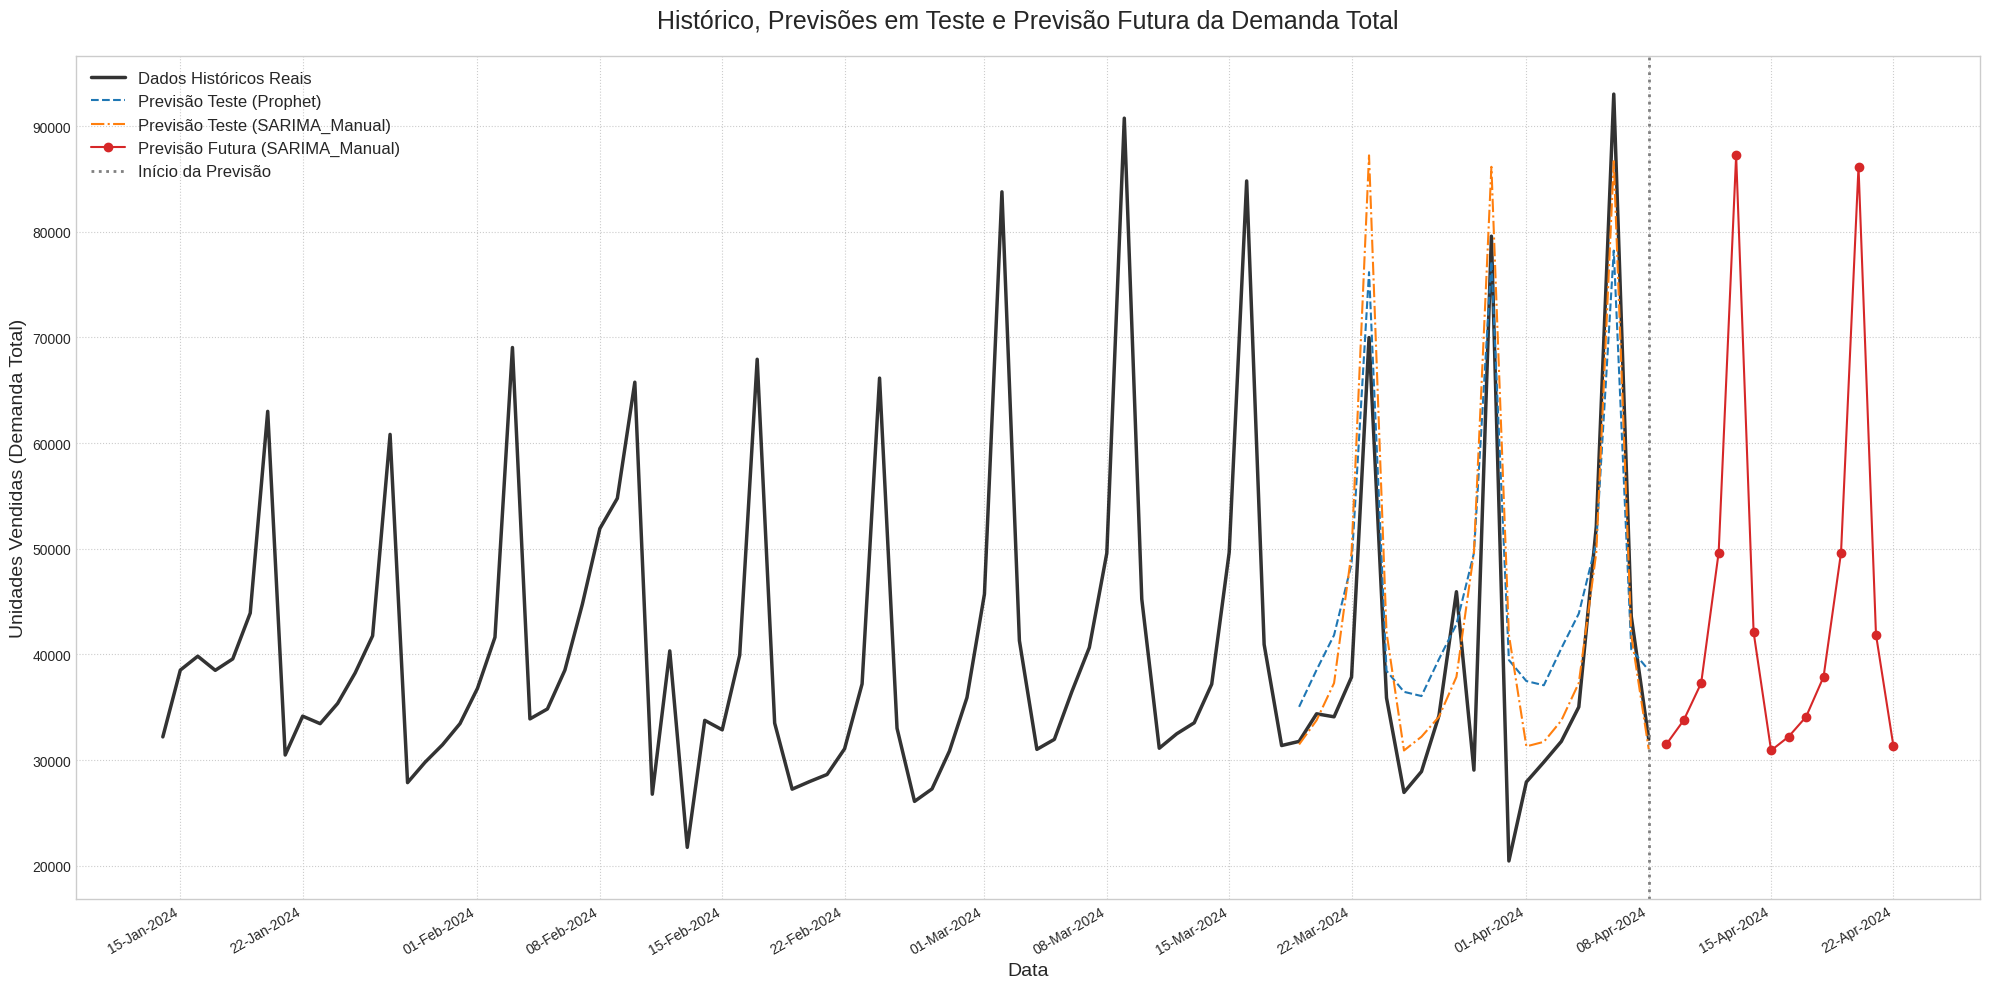


>> BÔNUS: PREVISÃO PARA UM GRUPO ESPECÍFICO DE PRODUTOS
Nenhum SKU fornecido. Previsão filtrada ignorada.

--- Script concluído. ---


In [14]:
# --- BLOCO FINAL: Visualização Consolidada e Uso Interativo ---
try:
    print("\n--- Gerando Gráfico Consolidado: Histórico + Previsões em Teste + Previsão Futura ---")
    dias_para_prever_futuro = 14
    previsao_futura_df = prever_demanda_filtrada(
        nome_modelo=melhor_modelo_nome,
        modelo_obj=melhor_modelo_obj,
        dados_historicos_raw=dados_raw,
        dados_historicos_agregados=dados_agregados,
        dias_a_prever=dias_para_prever_futuro
    )
    previsao_futura_series = previsao_futura_df.set_index('data_previsao')['previsao_demanda_total']

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.plot(dados_agregados.index, dados_agregados['demanda_total'], label='Dados Históricos Reais', color='black', linewidth=2.5, alpha=0.8)
    for nome, previsao in previsoes_teste.items():
        linestyle = '-.' if nome == melhor_modelo_nome else '--'
        ax.plot(teste.index, previsao, label=f'Previsão Teste ({nome})', linestyle=linestyle)

    ax.plot(previsao_futura_series.index, previsao_futura_series.values, label=f'Previsão Futura ({melhor_modelo_nome})', color='#d62728', linestyle='-', marker='o')
    ax.axvline(dados_agregados.index.max(), color='gray', linestyle=':', linewidth=2, label='Início da Previsão')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, fontsize=12, loc='upper left')
    ax.set_title('Histórico, Previsões em Teste e Previsão Futura da Demanda Total', fontsize=18, pad=20)
    ax.set_xlabel('Data', fontsize=14)
    ax.set_ylabel('Unidades Vendidas (Demanda Total)', fontsize=14)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    ax.grid(True, which='both', linestyle=':')
    plt.tight_layout()
    plt.show()

    print("\n>> BÔNUS: PREVISÃO PARA UM GRUPO ESPECÍFICO DE PRODUTOS")
    skus_input_str = input("Digite os SKUs para uma previsão filtrada, separados por vírgula (ou deixe em branco para pular): ").strip()
    if skus_input_str:
        skus_usuario = [sku.strip().upper() for sku in skus_input_str.split(',')]
        previsao_especifica = prever_demanda_filtrada(melhor_modelo_nome, melhor_modelo_obj, dados_raw, dados_agregados, lista_skus=skus_usuario)
        print(f"\n>> PREVISÃO FILTRADA PARA '{', '.join(skus_usuario)}':")
        print(previsao_especifica)
    else:
        print("Nenhum SKU fornecido. Previsão filtrada ignorada.")

except Exception as e:
    print(f"\nOcorreu um erro durante a execução da etapa final: {e}")
finally:
    print("\n--- Script concluído. ---")